In [1]:
import numpy as np
from pandas import read_csv

In [2]:
titanic_data_train = read_csv('datasets/titanic/titanic_training.csv')
titanic_data_test = read_csv('datasets/titanic/titanic_testing_data.csv')

In [3]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [57]:
from collections import Counter

import numpy as np
import pandas as pd
from numpy import genfromtxt
import scipy.io
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from pydot import graph_from_dot_data
import io

import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number


class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  
        self.split_idx, self.thresh = None, None 
        self.data, self.pred = None, None  

    def entropy(self, y):
        label_counts = Counter(y)
        probabilities = [count / len(y) for count in label_counts.values()]
        return -sum(p * np.log2(p) for p in probabilities if p > 0)
   
    
    def information_gain(self, X, y, idx, thresh):
        entropy_before = self.entropy(y)
        if idx >= len(X[0]):
            raise ValueError(f"Feature index {idx} out of bounds for dataset with {len(X[0])} features.")
        X_left, y_left, X_right, y_right = self.split(X, y, idx, thresh)
        entropy_after = (len(y_left) / len(y) * self.entropy(y_left) + 
                         len(y_right) / len(y) * self.entropy(y_right))
        return entropy_before - entropy_after

        # return np.random.rand()

    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO
        pass

    @staticmethod
    def gini_purification(X, y, thresh):
        # TODO
        pass

    def split(self, X, y, idx, thresh):
        #print(f"Splitting on Feature Index: {idx}, Threshold: {thresh}")
        y = np.array(y)
        if len(X) == 0:
            raise ValueError("Cannot split an empty dataset.")
        if idx >= len(X[0]):
            raise ValueError(f"Feature index {idx} out of bounds for dataset with {len(X[0])} features.")
    
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        #print(f"Splitting on feature {idx} at threshold {thresh}")
        #print(f"Left split size: {len(X0)}, Right split size: {len(X1)}")
        # if len(X0) == 0 or len(X1) == 0:
        #     print("Warning: Empty split detected.")
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        # TODO
        self.root = self._fit_tree(X, y, depth=0)
        #pass
    def _fit_tree(self, X, y, depth):
        
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return {"is_leaf": True, "prediction": Counter(y).most_common(1)[0][0]}
    
        best_gain = -1
        best_feature = None
        best_thresh = None
    
        for idx in range(X.shape[1]):
            #print(f"Depth: {depth}, Dataset Size: {len(X)}, Feature Index: {idx}")
            thresholds = np.unique(X[:, idx])
            
            for thresh in thresholds:
                gain = self.information_gain(X, y, idx, thresh) 
                if gain > best_gain:
                    best_gain = gain
                    best_feature = idx
                    best_thresh = thresh
    
        if best_gain == 0:
            return {"is_leaf": True, "prediction": Counter(y).most_common(1)[0][0]}
    
        X_left, y_left, X_right, y_right = self.split(X, y, best_feature, best_thresh)
    
        left_subtree = self._fit_tree(X_left, y_left, depth + 1)
        right_subtree = self._fit_tree(X_right, y_right, depth + 1)
    
        return {"is_leaf": False, "split_feature": best_feature, 
                "split_thresh": best_thresh, "left": left_subtree, 
                "right": right_subtree}

    def predict(self, X):
        # TODO
        #pass
        return np.array([self._predict_sample(sample, self.root) for sample in X])
    def _predict_sample(self, sample, node):
        if node["is_leaf"]:
            return node["prediction"]
        elif sample[node["split_feature"]] < node["split_thresh"]:
            return self._predict_sample(sample, node["left"])
        else:
            return self._predict_sample(sample, node["right"])

    def print_decision_path(self, sample, node=None, depth=0):
        if node is None:
            node = self.root
        
        if node["is_leaf"]:
            print(f"{'  ' * depth}-> Classify as: {'Spam' if node['prediction'] == 1 else 'Ham'}")
        else:
            feature = self.features[node["split_feature"]]
            threshold = node["split_thresh"]
            if sample[node["split_feature"]] < threshold:
                print(f"{'  ' * depth}-> Feature '{feature}' < {threshold}")
                self.print_decision_path(sample, node["left"], depth + 1)
            else:
                print(f"{'  ' * depth}-> Feature '{feature}' >= {threshold}")
                self.print_decision_path(sample, node["right"], depth + 1)

    
    

    
    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())


class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        self.params = params if params is not None else {}
        self.n = n
        self.decision_trees = []  

    def fit(self, X, y):
        X = np.array(X) if isinstance(X, (pd.DataFrame, pd.Series)) else X
        y = np.array(y) if isinstance(y, pd.Series) else y

        self.decision_trees = [] 
        for i in range(self.n):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            sampled_X, sampled_y = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.params.get('max_depth', 3)) 
            tree.fit(sampled_X, sampled_y)
            self.decision_trees.append(tree)

    def predict(self, X):
        # TODO
        # pass
        if not self.decision_trees:
            raise ValueError("This BaggedTrees instance is not fitted yet.")
    
        all_predictions = []
    
        for tree in self.decision_trees:
            tree_preds = tree.predict(X).astype(int)  
            all_predictions.append(tree_preds)
    
        predictions_array = np.array(all_predictions)
    
        if predictions_array.ndim == 2:
            final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)
            return final_predictions
        else:
            raise ValueError("Unexpected structure of aggregated predictions.")



class RandomForest(BaggedTrees):

    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        params['max_features'] = m
        self.m = m
        super().__init__(params=params, n=n)


class BoostedRandomForest(RandomForest):

    def __init__(self, params=None, n=200, m=1, num_boosting_rounds=10):
        super().__init__(params=params, n=n, m=m)
        self.num_boosting_rounds = num_boosting_rounds
        self.boosted_forests = []

    def fit(self, X, y):
        self.boosted_forests = [] 
        for _ in range(self.num_boosting_rounds):
            forest = RandomForest(self.params, self.n, self.m)
            forest.fit(X, y)
            self.boosted_forests.append(forest)

    def predict(self, X):
        if not self.boosted_forests:
            raise ValueError("No forests have been trained.")
        print([forest.predict(X).shape for forest in self.boosted_forests])

        predictions = [forest.predict(X) for forest in self.boosted_forests]
        
        predictions = np.array(predictions).astype(int)

        if predictions.ndim > 1:
            final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        elif predictions.ndim == 1:
            final_predictions = predictions
        else:
            raise ValueError("Unexpected structure of predictions.")

        return final_predictions

def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        # TODO
        # pass
        for col in range(data.shape[1]):
            col_data = list(data[:, col])
            most_common = Counter(col_data).most_common(1)[0][0]
            data[:, col] = [x if x != -1 else most_common for x in col_data]

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)
def evaluate_classifier(clf, X, y, features):
    evaluate(clf)
    
    print("Cross-validation scores:", cross_val_score(clf, X, y, cv=5))
    
    if hasattr(clf, "decision_trees"):
        counter = Counter([tree.tree_.feature[0] for tree in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits using clf.decision_trees:", first_splits)
    else:
        if hasattr(clf, 'tree_'):
            first_split_feature_index = clf.tree_.feature[0]
            if first_split_feature_index != -2: 
                print("First split feature using clf.tree_:", features[first_split_feature_index])
            else:
                print("The tree is a stump.")
        else:
            print("Classifier does not have tree_ attribute. Cannot print first split feature.")


if __name__ == "__main__":
    dataset = "titanic"
    # dataset = "spam"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data
        path_train = 'datasets/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=float).astype(int)
        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features", features)
    print("Train/test size", X.shape, Z.shape)
    
    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # sklearn decision tree
    print("\n\nsklearn's decision tree")
    clf = DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate(clf)
    out = io.StringIO()
    export_graphviz(
        clf, out_file=out, feature_names=features, class_names=class_names)
    # For OSX, may need the following for dot: brew install gprof2dot
    graph = graph_from_dot_data(out.getvalue())
    graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)
    
    # TODO
    print("\n\nsklearn's decision tree")
    clf = DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate_classifier(clf, X, y, features)
print("done")

/tmp/ipykernel_6788/2376682102.py:321: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
/tmp/ipykernel_6788/2376682102.py:323: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)




Part (b): preprocessing the titanic dataset
Features [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked', b'male', b'female', b'S', b'C', b'Q']
Train/test size (1009, 14) (300, 14)


Part 0: constant classifier
Accuracy 0.6194251734390486


sklearn's decision tree
Cross validation [0.81188119 0.81188119 0.76732673 0.79207921 0.78109453]


sklearn's decision tree
Cross validation [0.81188119 0.81188119 0.76732673 0.79207921 0.78109453]
Cross-validation scores: [0.81188119 0.81188119 0.76732673 0.79207921 0.78109453]
First split feature using clf.tree_: b'female'
done


In [58]:
def evaluate_model(clf, X_train, X_val, y_train, y_val):
    train_preds = clf.predict(X_train)
    val_preds = clf.predict(X_val)
    train_acc = accuracy_score(y_train, train_preds)
    val_acc = accuracy_score(y_val, val_preds)
    print(f"Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}")

<font size="+2">Titanic</font>

In [59]:
titanic_data_train.head()

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0.0,3.0,male,NaN,0.0,0.0,359309,8.0500,NaN,S
1,1.0,1.0,female,23.0,1.0,0.0,35273,113.2750,D36,C
2,0.0,3.0,NaN,38.0,0.0,0.0,SOTON/O.Q. 3101306,7.0500,NaN,S
3,0.0,2.0,male,NaN,0.0,0.0,SC/A.3 2861,15.5792,NaN,C
4,0.0,3.0,NaN,NaN,0.0,0.0,349227,7.8958,NaN,S


In [60]:
data = titanic_data_train.copy()
data.drop(['ticket', 'cabin', 'embarked'], axis=1, inplace=True, errors='ignore')


data['age'].fillna(data['age'].median(), inplace=True)
data['pclass'].fillna(data['pclass'].median(), inplace=True)
data['fare'].fillna(data['fare'].median(), inplace=True)
data['survived'].fillna(data['survived'].median(), inplace=True)
data['sibsp'].fillna(data['sibsp'].median(), inplace=True)
data['parch'].fillna(data['parch'].median(), inplace=True)


data['sex'] = data['sex'].map({'male': 0, 'female': 1})

data['sex'].fillna(data['sex'].median(), inplace=True)



X = data.drop('survived', axis=1)
y = data['survived']

print("Preprocessing done.")

Preprocessing done.


In [61]:
if X.isnull().values.any():
    print(X[X.isnull().any(axis=1)])

if y.isnull().values.any():
    print(y[y.isnull()])
print(y)
print(X.shape, y.shape)
print(data)

0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
1004    1.0
1005    0.0
1006    1.0
1007    1.0
1008    0.0
Name: survived, Length: 1009, dtype: float64
(1009, 6) (1009,)
      survived  pclass  sex   age  sibsp  parch      fare
0          0.0     3.0  0.0  29.0    0.0    0.0    8.0500
1          1.0     1.0  1.0  23.0    1.0    0.0  113.2750
2          0.0     3.0  0.0  38.0    0.0    0.0    7.0500
3          0.0     2.0  0.0  29.0    0.0    0.0   15.5792
4          0.0     3.0  0.0  29.0    0.0    0.0    7.8958
...        ...     ...  ...   ...    ...    ...       ...
1004       1.0     1.0  0.0  52.0    0.0    0.0   30.5000
1005       0.0     3.0  0.0  24.0    0.0    0.0    7.8958
1006       1.0     3.0  1.0  18.0    0.0    0.0    7.4958
1007       1.0     1.0  0.0  29.0    0.0    0.0   35.5000
1008       0.0     3.0  0.0  28.0    0.0    0.0    7.8542

[1009 rows x 7 columns]


In [62]:
dt_clf_custom = DecisionTree(max_depth=5)
dt_clf_custom.fit(X.values, y.values)

rf_clf_custom = RandomForest(params={"max_depth": 5, "min_samples_leaf": 10}, n=100, m=1)
rf_clf_custom.fit(X.values, y.values)

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_preds_dt = dt_clf_custom.predict(X_train.values)
val_preds_dt = dt_clf_custom.predict(X_val.values)

train_preds_rf = rf_clf_custom.predict(X_train.values)
val_preds_rf = rf_clf_custom.predict(X_val.values)


from sklearn.metrics import accuracy_score
print("decisiot tree accuracy:", accuracy_score(y_train, train_preds_dt))
print("det tree val acc:", accuracy_score(y_val, val_preds_dt))

print("rf train acc:", accuracy_score(y_train, train_preds_rf))
print("rf val acc:", accuracy_score(y_val, val_preds_rf))

decisiot tree accuracy: 0.8128872366790583
det tree val acc: 0.8415841584158416
rf train acc: 0.8240396530359355
rf val acc: 0.8415841584158416


In [64]:
test_data = titanic_data_test.copy()
test_data.drop(['ticket', 'cabin', 'embarked'], axis=1, inplace=True, errors='ignore')

test_data['age'].fillna(data['age'].median(), inplace=True) 
test_data['pclass'].fillna(data['pclass'].median(), inplace=True)
test_data['fare'].fillna(data['fare'].median(), inplace=True)
test_data['sibsp'].fillna(data['sibsp'].median(), inplace=True)
test_data['parch'].fillna(data['parch'].median(), inplace=True)

test_data['sex'] = test_data['sex'].map({'male': 0, 'female': 1})
test_data['sex'].fillna(data['sex'].median(), inplace=True) 


X_test = test_data

test_preds_dt = dt_clf_custom.predict(X_test.values)
test_preds_rf = rf_clf_custom.predict(X_test.values)

print("test preds from Decision Tree:", test_preds_dt)
print("test preds from Random Forest:", test_preds_rf)
print(len(test_preds_rf))

test preds from Decision Tree: [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
test preds from Random Forest: [1 1 0 1 0 0 0 0 0 0 0 0

In [11]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission_rf_titanic.csv', index_label='Id')
results_to_csv(test_preds_rf)
print("done")

done


In [65]:
def print_tree(node, depth=0, feature_labels=None):
    indent = "  " * depth
    if node['is_leaf']:
        print(f"{indent}Leaf: Predict {node['prediction']}")
    else:
        feature_name = feature_labels[node["split_feature"]] if feature_labels is not None else f"Feature {node['split_feature']}"
        print(f"{indent}{feature_name} < {node['split_thresh']} ?")
        if node['left']:  
            print(f"{indent}yes ->", end=" ")
            print_tree(node['left'], depth + 1, feature_labels)
        if node['right']:  
            print(f"{indent}no ->", end=" ")
            print_tree(node['right'], depth + 1, feature_labels)

print_tree(dt_clf_custom.root, feature_labels=features)

b'sex' < 1.0 ?
yes ->   b'pclass' < 2.0 ?
  yes ->     b'age' < 17.0 ?
    yes ->       Leaf: Predict 1.0
    no ->       b'age' < 55.0 ?
      yes ->         b'ticket' < 25.7417 ?
        yes ->           Leaf: Predict 0.0
        no ->           Leaf: Predict 0.0
      no ->         b'age' < 80.0 ?
        yes ->           Leaf: Predict 0.0
        no ->           Leaf: Predict 1.0
  no ->     b'age' < 4.0 ?
    yes ->       b'pclass' < 3.0 ?
      yes ->         Leaf: Predict 1.0
      no ->         b'age' < 3.0 ?
        yes ->           Leaf: Predict 0.0
        no ->           Leaf: Predict 1.0
    no ->       b'age' < 32.5 ?
      yes ->         b'age' < 32.0 ?
        yes ->           Leaf: Predict 0.0
        no ->           Leaf: Predict 0.0
      no ->         b'ticket' < 7.925 ?
        yes ->           Leaf: Predict 0.0
        no ->           Leaf: Predict 0.0
no ->   b'pclass' < 3.0 ?
  yes ->     b'ticket' < 31.6833 ?
    yes ->       b'parch' < 1.0 ?
      yes ->      

In [67]:
spam_data = scipy.io.loadmat('datasets/spam_data/spam_data.mat')

In [68]:
spam_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  3 21:01:43 2024',
 '__version__': '1.0',
 '__globals__': [],
 'training_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 'test_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'training_labels': array([[1., 0., 0., ..., 1., 1., 0.]])}

In [69]:
test_data = spam_data['test_data']

training_labels = spam_data['training_labels'].reshape(-1)

In [70]:
features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
print(len(Z))
print("done")

5400
done


In [71]:
print(len(Z))
from sklearn.model_selection import train_test_split
import scipy.io
print(len(Z))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(Z))

5400
5400
5400


In [72]:
dt_clf_custom = DecisionTree(max_depth=5)  
print(len(Z))
dt_clf_custom.fit(X_train, y_train)
print(len(Z))
evaluate_model(dt_clf_custom, X_train, X_val, y_train, y_val)
print(len(Z))
print("done")

5400
5400
Training Accuracy: 0.8252276260270931, Validation Accuracy: 0.8010657193605684
5400
done


In [73]:
rf_clf_custom = RandomForest(params={"max_depth": 5, "min_samples_leaf": 10}, n=100, m=1)

rf_clf_custom.fit(X_train, y_train)

evaluate_model(rf_clf_custom, X_train, X_val, y_train, y_val)
print("done")
print(len(Z))
print(Z.shape)

Training Accuracy: 0.8272262935820565, Validation Accuracy: 0.8010657193605684
done
5400
(5400, 32)


In [74]:
sample_data = np.random.rand(1, 32)  
print("DecisionTree preds on sample:", dt_clf_custom.predict(sample_data))
print("RandomForest preds on sampl:", rf_clf_custom.predict(sample_data))

DecisionTree preds on sample: [0.]
RandomForest preds on sampl: [0]


In [75]:
predictions_rf_spam = rf_clf_custom.predict(Z)
print("done")

predictions_dt_spam = dt_clf_custom.predict(Z)
print("done")
print(len(predictions_rf_spam))

done
done
5400


In [160]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission_spam_dt.csv', index_label='Id')
results_to_csv(predictions_dt_spam)

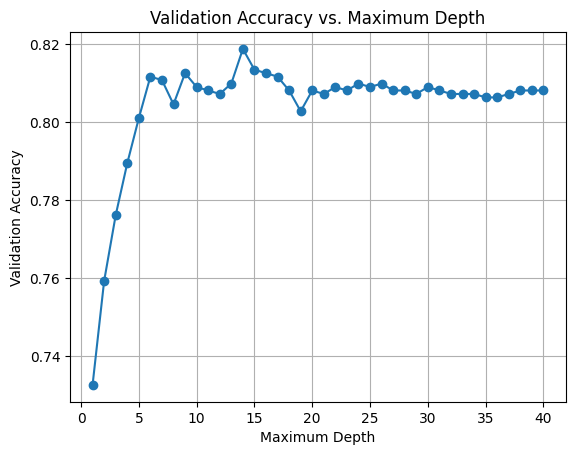

The highest validation accuracy is at depth 14: 0.8188


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


val_accuracies = []
depths = range(1, 41) 
best_depth = None
best_accuracy = 0

for depth in depths:
    model = DecisionTree(max_depth=depth, feature_labels=features)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    val_accuracy = accuracy_score(y_val, y_pred)
    
    val_accuracies.append(val_accuracy)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_depth = depth

plt.plot(depths, val_accuracies, marker='o')
plt.xlabel('Maximum Depth')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Maximum Depth')
plt.grid(True)
plt.show()

print(f"The highest validation accuracy is at depth {best_depth}: {best_accuracy:.4f}")

In [77]:
spam_indices = [i for i, label in enumerate(y_train) if label == 1]
ham_indices = [i for i, label in enumerate(y_train) if label == 0]

sample_spam = X_train[spam_indices[0]]
sample_ham = X_train[ham_indices[0]]

dt_clf_custom.features = features  

print("decision path for a spam:")
dt_clf_custom.print_decision_path(sample_spam)

print("decision path for a ham:")
dt_clf_custom.print_decision_path(sample_ham)



decision path for a spam:
-> Feature 'exclamation' >= 1.0
  -> Feature 'parenthesis' < 1.0
    -> Feature 'money' < 1.0
      -> Feature 'dollar' < 2.0
        -> Feature 'ampersand' < 1.0
          -> Classify as: Spam
decision path for a ham:
-> Feature 'exclamation' < 1.0
  -> Feature 'parenthesis' < 1.0
    -> Feature 'meter' >= 1.0
      -> Classify as: Ham
